In [60]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

In [61]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pickle

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.9.1.post3


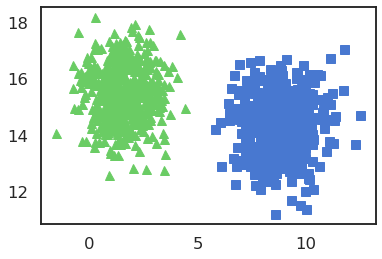

In [62]:
from sklearn import datasets

X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=2, center_box=(0, 20))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [63]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))

len train: 800
len test: 200


In [64]:
BATCH_SIZE = 32
n_features = 2
training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).float())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [65]:
def accuracy(model, test_loader):
    correct = 0

    for examples, labels in test_loader:
        output = model.forward(examples)
        batch_correct = torch.sum(torch.abs(torch.flatten(output) - labels) < 0.5)
        correct += batch_correct

    acc = float(correct)/len(testing_dataset)
    
    return acc

In [66]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=5, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden, bias=False),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden, bias=False),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1, bias=False),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [187]:
n_classes = 1
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=256):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_classes)
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [188]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    
    inp = Variable(inputs, requires_grad=True)
    outputs = model.forward(inp)
    loss = criterion(torch.squeeze(outputs), torch.squeeze(labels))

    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)

    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p=2)
    grad_l1_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p=1)

    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True, create_graph=True)[0]
    sensitivity_vec1 = torch.autograd.grad(grad_l1_norm, inp, retain_graph=True, create_graph=True)[0]

    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s1 = [torch.norm(v, p=1).detach().numpy().item() for v in sensitivity_vec1]
    s2 = [torch.norm(v, p=2).detach().numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''
    
    norm_tensor = torch.norm(sensitivity_vec1, p=1, dim=1)
    # we can pick any of the sensitivities because their derivatives are all the same
    idx = 0
    is_prime = torch.autograd.grad(norm_tensor[idx], inp, retain_graph=True)[0]
    beta = torch.norm(is_prime[idx], p=1).detach().numpy().item()
    
    loss.backward()
    return loss, s1, s2, beta

In [189]:
def plot_decision_boundary(X, y, model, loss, steps=1000, cmap='Paired', title=None):
    cmap = plt.get_cmap(cmap)
    #torch.abs(torch.flatten(output) - labels) < 0.5

    xmin, xmax = 0, 30
    ymin, ymax = 0, 20
    # Define region of interest by data limits
#     xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
#     ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    mesh_examples = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    labels = model.forward(mesh_examples) < 0.5

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape).detach().numpy()

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # get sensitivities of the data
    _, sensitivities = grad_immediate_sensitivity(model, 
                                                  loss, 
                                                  torch.from_numpy(X).float(), 
                                                  torch.from_numpy(y).float(), 
                                                  None)
    
    # Get predicted labels on training data and plot
    train_labels = model.forward(torch.from_numpy(X).float())
    #ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)
    ax.scatter(X[:,0], X[:,1], s=5*(np.array(sensitivities)-10), c=sensitivities, cmap='binary', lw=0)

    if title != None:
        plt.title(title)
    
    return fig, ax

In [269]:
def run_experiment(epsilon):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 20
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 25
    epsilon_iter = epsilon / epochs
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    mean_l1 = []
    max_l1 = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    all_batch_mean_sensitivities = []
    all_batch_max_sensitivities = []
    all_batch_mean_l1 = []
    all_batch_max_l1 = []

    for epoch in range(epochs):
#         print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        all_l1 = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            loss, l1, l2, beta = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(l2)# / BATCH_SIZE
            all_sensitivities.extend(l2)
            all_batch_mean_sensitivities.append(np.mean(l2) / BATCH_SIZE)
            all_batch_max_sensitivities.append(np.max(l2) / BATCH_SIZE)
            
            batch_l1 = np.max(l1) + beta # / BATCH_SIZE
            #print('batch sensitivity', batch_l1)
            #print('batch beta', beta)
            all_l1.extend(l1)
            all_batch_mean_l1.append(np.mean(l1) / BATCH_SIZE)
            all_batch_max_l1.append(np.max(l1) / BATCH_SIZE)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)
            
            # smooth upper bound
            t = 0.1
            smoothed = np.max([(batch_l1 + k*beta)*np.exp(-t * k) for k in range(len(x_batch_train))])
            #print('smoothed sens', smoothed)

            # For RDP and smooth sensitivity
            # calculating renyi divergence directly
            t = beta
            gamma = alpha * (np.exp(t) - 1) + 1
            sigma_sq = 2*gamma**2 * smoothed**2 / (4* epsilon_iter * gamma**2 - alpha * t**2)
            sigma = np.sqrt(sigma_sq)

            #print('Smooth:', sigma)

            # Assuming IS is a bound on GS (no smooth sensitivity)
            #sigma = np.sqrt(((smoothed)**2 * alpha) / (2 * epsilon_iter))

            #print('Global:', sigma)
            
            with torch.no_grad():
                for p in model.parameters():
                    p.grad += (sigma * torch.randn(tuple(p.shape)).float())

            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        mean_sensitivities.append(np.mean(all_sensitivities))
        max_l1.append(np.max(all_l1))
        mean_l1.append(np.mean(all_l1))
        max_sigmas.append(np.max(sigmas))        
        mean_sigmas.append(np.mean(sigmas))
        test_accs.append(accuracy(model, test_loader))
        
        #plot_decision_boundary(X, y, model, nn.BCELoss(), steps=100, title=f'Epoch {epoch}')
        
#         print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
#         print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
#         print("Max sigma for the epoch:", max_sigmas[-1])
#         print("Mean sigma for the epoch:", mean_sigmas[-1])

#         print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_l1, mean_l1, max_sigmas, 
                                          mean_sigmas, test_accs,
                                          all_batch_mean_sensitivities, all_batch_max_sensitivities, 
                                          all_batch_mean_l1, all_batch_max_l1), model

In [272]:
final_acc, info_tuple, model = run_experiment(2.0)
print("Final accuracy:", final_acc)

Final accuracy: 0.96


In [273]:
accs = []
for _ in range(10):
    final_acc, info_tuple, model = run_experiment(2.0)
    print(final_acc)
    accs.append(final_acc)


0.96
0.93
0.555
0.715
0.485
0.96
0.905
0.935
0.96
0.96


In [274]:
np.mean(accs)

0.8365

In [275]:
def get_eps(epsilon, alpha, delta):
    ed_eps = epsilon + np.log(1/delta)/(alpha - 1)
    print(f'Total epsilon = {ed_eps}, delta = {delta}')
    return ed_eps

In [276]:
get_eps(2.0, 20, 1e-5)

Total epsilon = 2.605943445524749, delta = 1e-05


2.605943445524749

In [238]:
max_l2, mean_l2, max_l1, mean_l1 = info_tuple[1:5]

In [115]:
xs = list(range(len(max_l1)))

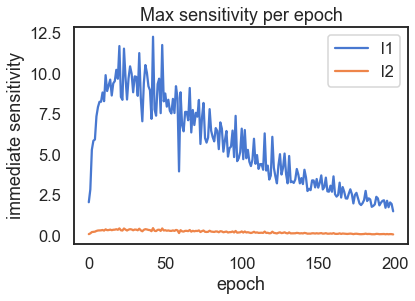

In [116]:
plt.plot(xs, max_l1, label='l1')
plt.plot(xs, max_l2, label='l2')
plt.title('Max sensitivity per epoch')
plt.xlabel('epoch')
plt.ylabel('immediate sensitivity')
plt.legend()

In [33]:
ratio = [l1/l2 for l1, l2 in zip(max_l1, max_l2)]

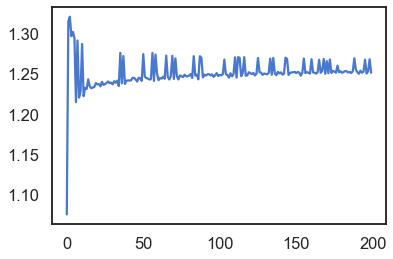

In [34]:
plt.plot(xs, ratio)

In [58]:
features = pickle.load(open("../../inputs/texas_100_features.p", 'rb')).astype(np.float32)
labels = pickle.load(open("../../inputs/texas_100_labels.p", 'rb'))


ds = list(zip(features, labels))
_, ds = train_test_split(ds, shuffle=True, random_state=7)

texas_train, texas_test = train_test_split(ds, test_size=.3, shuffle=True, random_state=7)

print("test 2")

class Texas_Classifier(nn.Module):
    def __init__(self, w):
        super(Texas_Classifier, self).__init__()
        self.fc1 = nn.Linear(6169, w)
        self.fc2 = nn.Linear(w, w)
        self.fc3 = nn.Linear(w, 100)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return torch.log_softmax(x,dim=1)

test 2


In [68]:
BATCH_SIZE = 64

train_loader = DataLoader(texas_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_loader = DataLoader(texas_test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [73]:
def loader_accuracy(model, test_loader, lf=nn.NLLLoss()):
    lossies = []
    accs = []
    #grab a batch from the test loader
    with torch.no_grad():
        for examples, labels in test_loader:
            outputs = model.forward(examples)
            lossies.append(lf(torch.squeeze(outputs), torch.squeeze(labels)).item())
            
            #for each output in the batch, check if the label is correct
            preds = np.argmax(outputs.detach().numpy(), axis=1)
            labels = labels.detach().numpy()
            accuracy = (preds == labels).mean()
            accs.append(accuracy)

    loss = sum(lossies)/len(lossies)
    acc = sum(accs)/len(accs)
    
    return acc, loss

In [77]:
def run_experiment(epsilon):
    # reset the model
    model = Texas_Classifier(256)
    model_criterion = nn.NLLLoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 20
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 25
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    mean_l1 = []
    max_l1 = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    all_batch_mean_sensitivities = []
    all_batch_max_sensitivities = []
    all_batch_mean_l1 = []
    all_batch_max_l1 = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        all_l1 = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            loss, l1, l2 = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(l2) / BATCH_SIZE
            all_sensitivities.extend(l2)
            all_batch_mean_sensitivities.append(np.mean(l2) / BATCH_SIZE)
            all_batch_max_sensitivities.append(np.max(l2) / BATCH_SIZE)
            
            batch_l1 = np.max(l1) / BATCH_SIZE
            all_l1.extend(l1)
            all_batch_mean_l1.append(np.mean(l1) / BATCH_SIZE)
            all_batch_max_l1.append(np.max(l1) / BATCH_SIZE)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)

#             with torch.no_grad():
#                 for p in model.parameters():
#                     p.grad += (sigma * torch.randn(1).float())

            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        mean_sensitivities.append(np.mean(all_sensitivities))
        max_l1.append(np.max(all_l1))
        mean_l1.append(np.mean(all_l1))
        max_sigmas.append(np.max(sigmas))        
        mean_sigmas.append(np.mean(sigmas))
        test_accs.append(loader_accuracy(model, test_loader))
        
        #plot_decision_boundary(X, y, model, nn.BCELoss(), steps=100, title=f'Epoch {epoch}')
        
#         print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
#         print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
#         print("Max sigma for the epoch:", max_sigmas[-1])
#         print("Mean sigma for the epoch:", mean_sigmas[-1])

#         print("Accuracy:", test_accs[-1])
    return loader_accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_l1, mean_l1, max_sigmas, 
                                          mean_sigmas, test_accs,
                                          all_batch_mean_sensitivities, all_batch_max_sensitivities, 
                                          all_batch_mean_l1, all_batch_max_l1), model

In [78]:
final_acc, info_tuple, model = run_experiment(10.1)

Start of epoch 0
Start of epoch 1
Start of epoch 2
Start of epoch 3
Start of epoch 4
Start of epoch 5
Start of epoch 6
Start of epoch 7
Start of epoch 8
Start of epoch 9
Start of epoch 10
Start of epoch 11
Start of epoch 12
Start of epoch 13
Start of epoch 14
Start of epoch 15
Start of epoch 16
Start of epoch 17
Start of epoch 18
Start of epoch 19


In [84]:
mean_l2, max_l2, mean_l1, max_l1 = info_tuple[-4:]

In [85]:
xs = list(range(len(max_l1)))

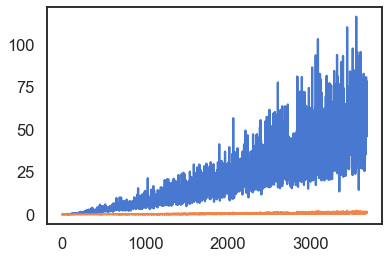

In [86]:
plt.plot(xs, max_l1)
plt.plot(xs, max_l2)

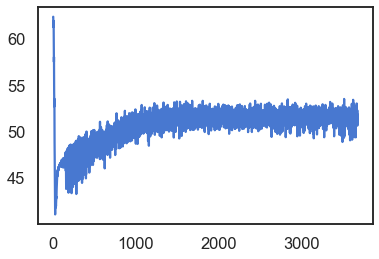

In [87]:
ratio = [l1/l2 for l1, l2 in zip(max_l1, max_l2)]
plt.plot(xs, ratio)